## Naive Bayes Model

## Due date

March 23, 2023

N.B.: You are allowed to consult lecture notebooks, the kaggle competition, ChatGPT, and Stack Overflow. You are also permitted to work with one other student.

## Assignment description


Your task is to train a Naive Bayes model on the [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data). The dataset contains 15,000 movie reviews. Your task is to train a Naive Bayes model on the training set and predict the labels of the test set. You will be evaluated on the methodologies you use to train the model and a comparison of your solutions. Your higest performing model will become your baseline model.

### Data

The dataset contains movie reviews from Rotten Tomatoes. Each review is labeled as follows:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In addition to the entire review, the reviews are split into phrases and each phrase is labeled. The entire review is assigned a `SentenceID` and each phrase is assigned a `PhraseID`. The phrases were produced by the Stanford Parser (stanza). You are free to use the entire review or the phrases to train your model. In addition, you are free to create additional features from the data (such as Brown Tags). Finally, you are free to adjust the labels to negative, neutral, positive, if a classificaiton report demonstrates that a certain label is underperforming.

## Section 0: Load the data

In [1]:
import pandas as pd
import numpy as np

train_url = 'https://raw.githubusercontent.com/JamesMTucker/DATA_340_NLP/master/assignment_notebooks/data/nb_train.tsv'
test_url = 'https://raw.githubusercontent.com/JamesMTucker/DATA_340_NLP/master/assignment_notebooks/data/nb_test.tsv'

train_df = pd.read_csv(train_url, sep='\t')
test_df = pd.read_csv(test_url, sep='\t')

In [2]:
## train data
train_df.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [3]:
train_df.shape #156060 training data, what will be split into train and validation data

(156060, 4)

In [4]:
## test data
test_df.head(20)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [5]:
test_df.shape #66292 rows for the test data

(66292, 3)

## Section 1: Data Exploration

In the following section, please explore the data. You should explore the data to understand the following:

* has the data been preprocessed already?
* How many reviews are in the dataset?
* How many phrases are in the dataset?
* What is the distribution of the labels? (i.e. how many reviews are negative, neutral, positive)
* What is the distribution of the labels for each phrase? (i.e. how many phrases are negative, neutral, positive)
* What is the distribution of the words/tokens in the dataset?
* How many unique words are in the dataset?

In [6]:
### YOUR CODE HERE
#exploration will be for the training data set

In [7]:
# Has the data been preprocessed?
# No it has not been, there are capital letters and punctuation which will have to be removed
train_df['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [8]:
#How many reviews in the dataset
# Remove non unique sentenceIds and keep the first one since the sentance id which is a unique identifier for each review, that shape will tell how many reviews
review_train_df = train_df.drop_duplicates(subset = ['SentenceId']).reset_index(drop = True)
review_train_df #there are a total of 8529 reviews in the dataset

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,64,2,"This quiet , introspective and entertaining in...",4
2,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
3,117,4,A positively thrilling combination of ethnogra...,3
4,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
8524,155985,8540,... either you 're willing to go with this cla...,2
8525,155998,8541,"Despite these annoyances , the capable Claybur...",2
8526,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
8527,156032,8543,The movie 's downfall is to substitute plot fo...,1


In [9]:
len(train_df['SentenceId'].unique()) #there are only 8529 unique sentence ids even though it says it goes up to 8, not sure why they disagree

8529

In [10]:
# How many phrases are in the dataset?
# this is just the amount of rows in the trianing data set because each row is a phrase
phrase_train_df = train_df.drop_duplicates()
phrase_train_df.shape #there are 156060 phrases

(156060, 4)

In [11]:
# What is the distribution of the labels? (i.e. how many reviews are negative, neutral, positive)
review_train_df['Sentiment'].value_counts(sort = True)
#There are mostly somewhat positive, then slighlty negative, then neutral, then very positive, and then fully negative

3    2321
1    2200
2    1655
4    1281
0    1072
Name: Sentiment, dtype: int64

In [12]:
# What is the distribution of the labels for each phrase? (i.e. how many phrases are negative, neutral, positive)
phrase_train_df['Sentiment'].value_counts(sort = True) 
#the phrases have more neutral than the reviews

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [38]:
# What is the distribution of the words/tokens in the dataset?
# using the token data frame that I created in the data processing step, shown in section 2.
token_data = review_train_df.explode('tokens')
token_frequency = (token_data
                  .groupby(by=['tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'token_frequency'})
                  .reset_index()
                  .sort_values(by = 'token_frequency', ascending = False))
token_frequency

,tokens,token_frequency
5069,film,1154
8705,movie,1008
6,...,633
3,--,506
7789,like,504
...,...,...
6811,ineffable,1
6812,ineffective,1
6815,ineptitude,1
6820,inescapably,1


In [39]:
# How many unique words are in the dataset?
#There are 15024 unique tokens in the dataset from the dataframe above

## Section 2: Data Preprocessing

In the following section, please preprocess the data. How you preprocess the data will align with what features you are engineering for your model. This might include: tokenization, lemmatization, stemming, removing stopwords, etc. You should also consider how you will handle the labels. You might consider the following: one-hot encoding, label encoding, etc.

In [15]:
### YOUR CODE HERE
# Imports
import spacy
import string

In [22]:
from tqdm.auto import tqdm
tqdm.pandas()
NLP = spacy.load('en_core_web_sm')

In [37]:
# Create tokens
punctuation = list(string.punctuation)
whitespace = list(string.whitespace)[1:] #want to remove the new line characters and tabs, don't want to remove all space though so take after first index
undesired_characters = punctuation + whitespace + list(spacy.lang.en.stop_words.STOP_WORDS)
review_train_df['tokens'] = review_train_df['Phrase'].progress_apply(lambda x: 
                                             [x.text.lower() for x in NLP(x) if x.text.lower() not in undesired_characters]) 

  0%|          | 0/8529 [00:00<?, ?it/s]

In [36]:
review_train_df

,PhraseId,SentenceId,Phrase,Sentiment,tokens
0,1,1,A series of escapades demonstrating the adage ...,1,"[a, series, of, escapades, demonstrating, the,..."
1,64,2,"This quiet , introspective and entertaining in...",4,"[this, quiet, introspective, and, entertaining..."
2,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1,"[even, fans, of, ismail, merchant, 's, work, i..."
3,117,4,A positively thrilling combination of ethnogra...,3,"[a, positively, thrilling, combination, of, et..."
4,157,5,Aggressive self-glorification and a manipulati...,1,"[aggressive, self, glorification, and, a, mani..."
...,...,...,...,...,...
8524,155985,8540,... either you 're willing to go with this cla...,2,"[..., either, you, 're, willing, to, go, with,..."
8525,155998,8541,"Despite these annoyances , the capable Claybur...",2,"[despite, these, annoyances, the, capable, cla..."
8526,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1,"[-lrb-, tries, -rrb-, to, parody, a, genre, th..."
8527,156032,8543,The movie 's downfall is to substitute plot fo...,1,"[the, movie, 's, downfall, is, to, substitute,..."


In [62]:
# attempt 2: Change sentiment to be 0, 1, 2, neutral is 1, bad is 0, positive is 2
sentiment_train_df = review_train_df.copy()

In [67]:
new_sentiments = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}
sentiment_train_df['Sentiment'] = sentiment_train_df['Sentiment'].map(new_sentiments)
sentiment_train_df

,PhraseId,SentenceId,Phrase,Sentiment,tokens
0,1,1,A series of escapades demonstrating the adage ...,0,"[series, escapades, demonstrating, adage, good..."
1,64,2,"This quiet , introspective and entertaining in...",2,"[quiet, introspective, entertaining, independe..."
2,82,3,"Even fans of Ismail Merchant 's work , I suspe...",0,"[fans, ismail, merchant, work, suspect, hard, ..."
3,117,4,A positively thrilling combination of ethnogra...,2,"[positively, thrilling, combination, ethnograp..."
4,157,5,Aggressive self-glorification and a manipulati...,0,"[aggressive, self, glorification, manipulative..."
...,...,...,...,...,...
8524,155985,8540,... either you 're willing to go with this cla...,1,"[..., willing, claustrophobic, concept]"
8525,155998,8541,"Despite these annoyances , the capable Claybur...",1,"[despite, annoyances, capable, clayburgh, tamb..."
8526,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,0,"[-lrb-, tries, -rrb-, parody, genre, joke, uni..."
8527,156032,8543,The movie 's downfall is to substitute plot fo...,0,"[movie, downfall, substitute, plot, personality]"


In [146]:
# Attempt 4: Using the phrase data frame
phrase_train_df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [156]:
# Fifth Attempt: Using the phrase data frame but making it only 0, 1, 2 for bad, neutral, positive
less_sentiment_phrase = phrase_train_df.copy()
new_sentiments = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}
less_sentiment_phrase['Sentiment'] = less_sentiment_phrase['Sentiment'].map(new_sentiments)
less_sentiment_phrase

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,0
1,2,1,A series of escapades demonstrating the adage ...,1
2,3,1,A series,1
3,4,1,A,1
4,5,1,series,1
...,...,...,...,...
156055,156056,8544,Hearst 's,1
156056,156057,8544,forced avuncular chortles,0
156057,156058,8544,avuncular chortles,2
156058,156059,8544,avuncular,1


## Section 3: Feature Engineering

In this section, you should engineer features for your model. You could consider the following: bag of words, tf-idf, brown tags.

In [85]:
### YOUR CODE HERE
# I decided to do the train test split for each model just to make sure I had all of the values in order, especially with swithcing
# between 5 or 3 sentiment values. 
# Attempt 1: Creating vector representation of the values
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [172]:
#do the train test split on the phrase instead of tokenizer because the vectorizer doesn't want a list
X_train_1, X_validation_1, y_train_1, y_validation_1 = train_test_split(review_train_df['Phrase'], 
                                                                        review_train_df['Sentiment'], test_size=0.2, random_state=33)

In [173]:
vectorizer_1 = CountVectorizer(stop_words='english')

X_train_1_vectors = vectorizer_1.fit_transform(X_train_1)
X_validation_1_vectors = vectorizer_1.transform(X_validation_1)

In [174]:
# Attempt 2: CountVectorizer but with labels of 0, 1, 2
X_train_2, X_validation_2, y_train_2, y_validation_2 = train_test_split(sentiment_train_df['Phrase'], 
                                                                        sentiment_train_df['Sentiment'], test_size=0.2, random_state=33)

In [175]:
vectorizer_2 = CountVectorizer(stop_words='english')

X_train_2_vectors = vectorizer_2.fit_transform(X_train_2)
X_validation_2_vectors = vectorizer_2.transform(X_validation_2)

In [176]:
# Attempt 3: Look at TF-IDF pipeline
X_train_3, X_validation_3, y_train_3, y_validation_3 = train_test_split(review_train_df['Phrase'], 
                                                                        review_train_df['Sentiment'], test_size=0.2, random_state=33)

In [177]:
# Attempt 4: Look at count vectorizer but with the phrase data frame
X_train_4, X_validation_4, y_train_4, y_validation_4 = train_test_split(phrase_train_df['Phrase'], 
                                                                        phrase_train_df['Sentiment'], test_size=0.2, random_state=33)

In [178]:
vectorizer_4 = CountVectorizer(stop_words='english')

X_train_4_vectors = vectorizer_4.fit_transform(X_train_4)
X_validation_4_vectors = vectorizer_4.transform(X_validation_4)

In [179]:
# Fifth Attempt: Using the phrase data frame but making it only 0, 1, 2 for bad, neutral, positive
X_train_5, X_validation_5, y_train_5, y_validation_5 = train_test_split(less_sentiment_phrase['Phrase'], 
                                                                        less_sentiment_phrase['Sentiment'], test_size=0.2, random_state=33)

In [180]:
vectorizer_5 = CountVectorizer(stop_words='english')

X_train_5_vectors = vectorizer_5.fit_transform(X_train_5)
X_validation_5_vectors = vectorizer_5.transform(X_validation_5)

In [181]:
# Attempt 6: See if the phrases with the TF-IDF works
X_train_6, X_validation_6, y_train_6, y_validation_6 = train_test_split(phrase_train_df['Phrase'], 
                                                                        phrase_train_df['Sentiment'], test_size=0.2, random_state=33)

## Section 4: Model Training

In this section, you should engineer at least two models. You should train each model on the training set and evaluate the performance of each model on the test set. You should also compare the performance of each model. You should also explain the performance of each model.

In [182]:
### YOUR CODE HERE
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [183]:
# First attempt: Vectors with the bag of words
nb_1 = MultinomialNB()

nb_1.fit(X_train_1_vectors, y_train_1)

MultinomialNB()

In [184]:
# Second attempt
nb_2 = MultinomialNB()

nb_2.fit(X_train_2_vectors, y_train_2)

MultinomialNB()

In [185]:
# Third Attempt using TF-IDF Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [186]:
#creating the pipeline and 
text_clf_3 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

text_clf_3.fit(X_train_3, y_train_3)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [187]:
# Fourth Attempt Using the phrase data frame instead of review
nb_4 = MultinomialNB()

nb_4.fit(X_train_4_vectors, y_train_4)

MultinomialNB()

In [188]:
# Fifth Attempt: Using the phrase data frame but making it only 0, 1, 2 for bad, neutral, positive
nb_5 = MultinomialNB()

nb_5.fit(X_train_5_vectors, y_train_5)

MultinomialNB()

In [189]:
text_clf_6 = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

text_clf_6.fit(X_train_6, y_train_6)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Section 5: Model Evaluation

In this section, you should evaluate the performance of your model. You should consider the following: accuracy, precision, recall, f1-score, confusion matrix, classification report, etc.

In [190]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [191]:
### YOUR CODE HERE
# First attempt evaluation
y_pred_1 = nb_1.predict(X_validation_1_vectors)

accuracy = accuracy_score(y_validation_1, y_pred_1)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.39


<AxesSubplot:>

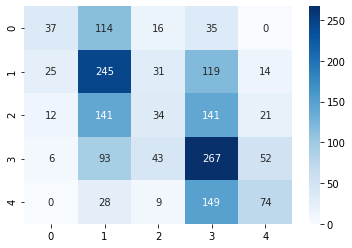

In [192]:
cfm = confusion_matrix(y_validation_1, y_pred_1)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
# does a good job on 3 and 1, a poor job on neutral and the extremes
# this discrepency could be because more of the training data is labeled at 3 or 1, not many 0 and 4

In [193]:
print(classification_report(y_validation_1, y_pred_1, target_names=['0', '1', '2', '3', '4']))

              precision    recall  f1-score   support

           0       0.46      0.18      0.26       202
           1       0.39      0.56      0.46       434
           2       0.26      0.10      0.14       349
           3       0.38      0.58      0.46       461
           4       0.46      0.28      0.35       260

    accuracy                           0.39      1706
   macro avg       0.39      0.34      0.34      1706
weighted avg       0.38      0.39      0.35      1706



In [194]:
# Second Attempt: using 3 sentiment values (0, 1, 2)
y_pred_2 = nb_2.predict(X_validation_2_vectors)

accuracy = accuracy_score(y_validation_2, y_pred_2)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.61


<AxesSubplot:>

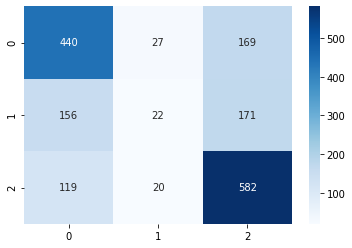

In [195]:
cfm = confusion_matrix(y_validation_2, y_pred_2)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
# does a significantly better job with a reduced representation of options, still bad at identifying neutral values

In [196]:
print(classification_report(y_validation_2, y_pred_2, target_names=['0', '1', '2']))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       636
           1       0.32      0.06      0.11       349
           2       0.63      0.81      0.71       721

    accuracy                           0.61      1706
   macro avg       0.52      0.52      0.49      1706
weighted avg       0.56      0.61      0.56      1706



In [197]:
# Third attempt evaluation: TF-IDF pipeline trained on reviews
y_pred_3 = text_clf_3.predict(X_validation_3)
accuracy = accuracy_score(y_validation_3, y_pred_3)
print(f'Accuracy: {accuracy:.2f}')
# does slighltly worse than the first attempt

Accuracy: 0.38


<AxesSubplot:>

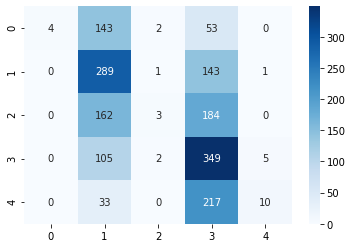

In [198]:
cfm = confusion_matrix(y_validation_3, y_pred_3)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
# still predicting 1 and 3 way more than the other values

In [199]:
print(classification_report(y_validation_3, y_pred_3, target_names=['0', '1', '2', '3', '4']))
#wasn't very good

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       202
           1       0.39      0.67      0.50       434
           2       0.38      0.01      0.02       349
           3       0.37      0.76      0.50       461
           4       0.62      0.04      0.07       260

    accuracy                           0.38      1706
   macro avg       0.55      0.30      0.22      1706
weighted avg       0.49      0.38      0.28      1706



In [200]:
# Attempt 4: Training on the phrase data frame instead of the whole review, has 5 sentiment values
y_pred_4 = nb_4.predict(X_validation_4_vectors)

accuracy = accuracy_score(y_validation_4, y_pred_4)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.61


<AxesSubplot:>

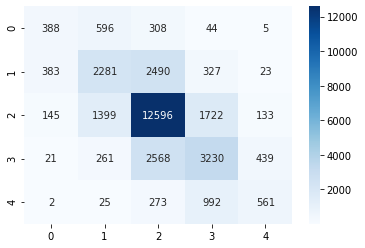

In [201]:
cfm = confusion_matrix(y_validation_4, y_pred_4)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4']) 
#does a good job on neutral but struggles some on the other values

In [202]:
print(classification_report(y_validation_4, y_pred_4, target_names=['0', '1', '2', '3', '4']))

              precision    recall  f1-score   support

           0       0.41      0.29      0.34      1341
           1       0.50      0.41      0.45      5504
           2       0.69      0.79      0.74     15995
           3       0.51      0.50      0.50      6519
           4       0.48      0.30      0.37      1853

    accuracy                           0.61     31212
   macro avg       0.52      0.46      0.48     31212
weighted avg       0.60      0.61      0.60     31212



In [203]:
# Attempt 5: using the phrase dataframe and using only 3 sentiment values
y_pred_5 = nb_5.predict(X_validation_5_vectors)

accuracy = accuracy_score(y_validation_5, y_pred_5)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.68


<AxesSubplot:>

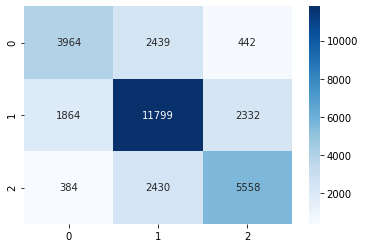

In [204]:
cfm = confusion_matrix(y_validation_5, y_pred_5)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
#does better but still guessing neutral (1) more than the other values
#the best model so far though

In [205]:
print(classification_report(y_validation_5, y_pred_5, target_names=['0', '1', '2']))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      6845
           1       0.71      0.74      0.72     15995
           2       0.67      0.66      0.67      8372

    accuracy                           0.68     31212
   macro avg       0.67      0.66      0.67     31212
weighted avg       0.68      0.68      0.68     31212



In [206]:
# Attempt 6
y_pred_6 = text_clf_6.predict(X_validation_6)
accuracy = accuracy_score(y_validation_6, y_pred_6)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.59


<AxesSubplot:>

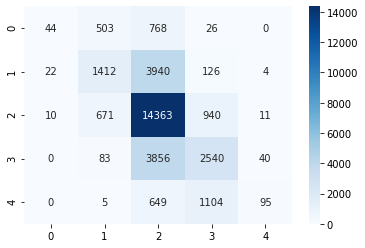

In [207]:
cfm = confusion_matrix(y_validation_6, y_pred_6)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
#slightly worse than the 4th attempt

In [208]:
print(classification_report(y_validation_6, y_pred_6, target_names=['0', '1', '2', '3', '4']))

              precision    recall  f1-score   support

           0       0.58      0.03      0.06      1341
           1       0.53      0.26      0.35      5504
           2       0.61      0.90      0.73     15995
           3       0.54      0.39      0.45      6519
           4       0.63      0.05      0.09      1853

    accuracy                           0.59     31212
   macro avg       0.58      0.33      0.34     31212
weighted avg       0.58      0.59      0.54     31212



## Section 6: Summary

Please answer the following questions:
    
* What is the performance of your model?



* What are the limitations of your model?



* What are the strengths of your model?



* What is the assumption of Naive Bayes? How does the assumption introduce bias into your model?



* Why do you think Naive Bayes is a popular model?
    

### Section 6 Responses

The model I am using is the CountVectorization Naive Bayes trained on the Phrases dataframe and with labels of 0, 1, 2 (negative, neutral, positive).

#### 1) What is the performance of your model?

The model had an accuracy of 68%. It had the best accuracy and recall for neutral sentiment reviews.  

#### 2) What are the liitations of your model?

The model is striped back and unable to make predictions of somewhat negative/positive. It only has 3 sentiment outcomes compared to 5 in the original data set. In addition, the model has a heavy bias towards predicting neutral (1) for the label compared to negative or positive. This means it is worse at identifying the positive or negative sentiments.

#### 3) What are the strenghts of your model?

The model is quick to create and use. It has the best accuracy of the 6 models I looked at. It uses a vector encoding of the words found in the reviews. The model was trained on more examples by using the phrases data frame instead of the review data frame. Additionaly, it tends towards picking neutral which can be better than guessing the extreme opposite of what the true sentiment is. 

#### 4) What is the assumption of Naive Bayes? How the assumption introduce bias into your model?

The assumption of Naive Bayes is that each word is independent from the others. It introduces bias by removing clear depdendency between words, making the model worse. 

#### 5) Why do you think Naive Bayes is a popular model?

Because it is quick to implement and can give some preliminary results. As well, it is simpler to understand and explain than some more complicated model architecture. 